In [1]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access the API key
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

print("GROQ_API_KEY loaded:", GROQ_API_KEY[:4] + "..." if GROQ_API_KEY else "API Key not found")

GROQ_API_KEY loaded: gsk_...


## SECTION 1: Basic LangGraph + LLM Setup

Why it's written:
I am using Groq as a backend for LLM inference.

ChatGroq connects to Groq's API with a specific model (Gemma2-9b-It).

You create an instance llm to interact with the LLM.

Note:-
You could replace Groq with OpenAI, Mistral, or Claude, depending on your API keys and performance.

In [2]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

Why it's written:
Just sending a string prompt to the LLM and getting the output.

Syntax:
invoke() is used to send a prompt.

.content is used to extract the actual text reply from the LLM’s response object.

In [3]:
llm_response = llm.invoke("hi").content
print(llm_response)

Hi! 👋

How can I help you today?



## SECTION 2: Create a Simple Workflow with LangGraph

In [4]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

Why it's written:

Importing key classes and utilities:

    StateGraph: To define your workflow.

    MessagesState: Built-in dict-like class to track messages between nodes.

    START, END: Predefined start/end points in a graph.

    tool, ToolNode: Used later for defining tools in the workflow.

    MemorySaver: Optional memory checkpointing to retain history.

In [5]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

Purpose:
    Defines a node function in your graph which will:

        1) Take in a list of messages

        2) Pass it to LLM

        3) Return a new message as a dictionary (state)

Syntax Note:
    
    The return must be a dictionary matching the state structure.

    Use state['messages'] to retrieve current context.

In [6]:
workflow=StateGraph(MessagesState)
workflow.add_node("chatbot",call_model)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot",END)
app=workflow.compile()

Why this is written:

    Defining a state-based graph with MessagesState.

    Adding a single node called chatbot.

    Connecting the START → chatbot → END.

    Compiling it into a runnable app (app).

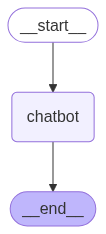

In [7]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

Purpose:
    Shows a graphical representation of the LangGraph workflow (optional).

In [9]:
input={"messages":["hi, my name is Gurmeet Singh"]}

In [10]:
app.invoke(input)

{'messages': [HumanMessage(content='hi, my name is Gurmeet Singh', additional_kwargs={}, response_metadata={}, id='62a5a67f-a9ba-461f-965c-23e55d053f40'),
  AIMessage(content="Hello Gurmeet Singh, it's nice to meet you! 👋\n\nWhat can I do for you today?\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 17, 'total_tokens': 43, 'completion_time': 0.047272727, 'prompt_time': 0.001931989, 'queue_time': 0.25835218, 'total_time': 0.049204716}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--df242929-c71a-4dd5-8f7b-ac5f8a4de360-0', usage_metadata={'input_tokens': 17, 'output_tokens': 26, 'total_tokens': 43})]}

## SECTION 3: Streaming Output

In [11]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from chatbot Node
_______
{'messages': [AIMessage(content="Hello Gurmeet Singh, it's nice to meet you! \n\nIs there anything I can help you with today?\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 17, 'total_tokens': 45, 'completion_time': 0.050909091, 'prompt_time': 0.001922668, 'queue_time': 0.258662942, 'total_time': 0.052831759}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--682a6b0d-c7e3-4b87-99d5-6715c2ee2c8e-0', usage_metadata={'input_tokens': 17, 'output_tokens': 28, 'total_tokens': 45})]}




Why it's written:

    Streams intermediate states of the graph.

    Helps in debugging and understanding what each node returns.

##  SECTION 4: Tool Integration

In [20]:
@tool
def search(query: str):
    """this is my custom tool."""
    if "usa" in query.lower() or "us" in query.lower():
        return "The Grand Canyon is one of the best places to visit in the USA for its breathtaking natural beauty."
    return "There are many other places in the world to visit like India, Japan, etc."

Purpose:

    Defines a custom tool function (search) that can be called by LLM when needed.

    Decorated with @tool so LangChain knows it can be used by the LLM.

Tool Invocation:

In [21]:
search.invoke("what is a the best place to visit in USA ?")

'The Grand Canyon is one of the best places to visit in the USA for its breathtaking natural beauty.'

Test call to see how your tool behaves.

In [23]:
search.invoke("What are the other countries to visit in the world?")

'There are many other places in the world to visit like India, Japan, etc.'

Test call to see how your tool behaves.

In [24]:
search

StructuredTool(name='search', description='this is my custom tool.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000025B882EA050>)

Tool Setup:

In [25]:
tools=[search]

In [26]:
tool_node=ToolNode(tools)

In [27]:
llm_with_tool=llm.bind_tools(tools)

Purpose:

Wrap tool into a ToolNode so it can be used in a LangGraph node.

Bind tools to the LLM so it knows how to call them when needed.

### Modify call_model to use tools:

In [28]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [29]:
response=call_model({"messages": ["hi how are you?"]})

In [30]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bbqe', 'function': {'arguments': '{"query":"how are you"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 940, 'total_tokens': 1021, 'completion_time': 0.147272727, 'prompt_time': 0.079598446, 'queue_time': 0.246231194, 'total_time': 0.226871173}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a1a70b90-ddff-4ce9-be15-284563029cc5-0', tool_calls=[{'name': 'search', 'args': {'query': 'how are you'}, 'id': 'call_bbqe', 'type': 'tool_call'}], usage_metadata={'input_tokens': 940, 'output_tokens': 81, 'total_tokens': 1021})]}

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bbqe', 'function': {'arguments': '{"query":"how are you"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 940, 'total_tokens': 1021, 'completion_time': 0.147272727, 'prompt_time': 0.079598446, 'queue_time': 0.246231194, 'total_time': 0.226871173}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a1a70b90-ddff-4ce9-be15-284563029cc5-0', tool_calls=[{'name': 'search', 'args': {'query': 'how are you'}, 'id': 'call_bbqe', 'type': 'tool_call'}], usage_metadata={'input_tokens': 940, 'output_tokens': 81, 'total_tokens': 1021})]}

In [32]:
messages = response['messages']

In [33]:
last_message=messages[-1]

In [34]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'how are you'},
  'id': 'call_bbqe',
  'type': 'tool_call'}]

In [35]:
response=call_model({"messages": ["what is a weather in India?"]})

In [36]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3mkw', 'function': {'arguments': '{"query":"weather in India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 942, 'total_tokens': 1023, 'completion_time': 0.147272727, 'prompt_time': 0.033069422, 'queue_time': 0.247366719, 'total_time': 0.180342149}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1ffeca6a-1999-457d-b25d-51b424280b93-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in India'}, 'id': 'call_3mkw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 942, 'output_tokens': 81, 'total_tokens': 1023})]}

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3mkw', 'function': {'arguments': '{"query":"weather in India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 942, 'total_tokens': 1023, 'completion_time': 0.147272727, 'prompt_time': 0.033069422, 'queue_time': 0.247366719, 'total_time': 0.180342149}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1ffeca6a-1999-457d-b25d-51b424280b93-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in India'}, 'id': 'call_3mkw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 942, 'output_tokens': 81, 'total_tokens': 1023})]}

In [37]:
messages = response['messages']

In [38]:
last_message=messages[-1]

In [39]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in India'},
  'id': 'call_3mkw',
  'type': 'tool_call'}]

## SECTION 5: Tool Calls & Routing

In [40]:
def router_function(state: MessagesState) -> Literal["tools", END]:
    #print(f"here is a state from should continue {state}")
    messages = state['messages']
    last_message = messages[-1]
    #print(f"here is a last message from should continue {last_message}")
    if last_message.tool_calls:
        return "tools"
    return END

Purpose:

1) Checks if LLM's response requests a tool.

2) If yes → route to "tools" node.

3) Else → finish (END).

Define multi-step graph:

In [41]:
# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

app = workflow.compile()

Flow:

START → agent (calls LLM) →

if tool is needed → tools → back to agent

else → END


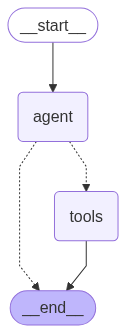

In [42]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [43]:
app.invoke({"messages": ["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='26824c7b-c2fc-4e3c-8f5c-11480539a116'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pa0s', 'function': {'arguments': '{"query":"how are you"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 940, 'total_tokens': 1022, 'completion_time': 0.149090909, 'prompt_time': 0.032845164, 'queue_time': 0.24592008699999998, 'total_time': 0.181936073}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d6585cb7-3901-4b07-92b5-b9acd2e56b94-0', tool_calls=[{'name': 'search', 'args': {'query': 'how are you'}, 'id': 'call_pa0s', 'type': 'tool_call'}], usage_metadata={'input_tokens': 940, 'output_tokens': 82, 'total_tokens': 1022}),
  ToolMessage(content='There are many other places in the world to visit like India, Japan, etc.', n

In [44]:
app.invoke({"messages": ["what is the weather in sf"]})

{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='38ee6658-8ad3-4cb2-9380-c54a25a6c7c1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8raw', 'function': {'arguments': '{"query":"weather in sf"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 941, 'total_tokens': 1023, 'completion_time': 0.149090909, 'prompt_time': 0.033032714, 'queue_time': 0.25075097599999996, 'total_time': 0.182123623}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--002adac4-8313-4d9a-82c1-b3f80f86eec0-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': 'call_8raw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 941, 'output_tokens': 82, 'total_tokens': 1023}),
  ToolMessage(content='There are many other places in the world to visit like India, J

### Add cycle (tool → agent):

In [45]:
workflow.add_edge("tools", 'agent')

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


This allows:

After tool execution, return to LLM for next step (like AutoGPT behavior).

Compile app:

In [46]:
app = workflow.compile()

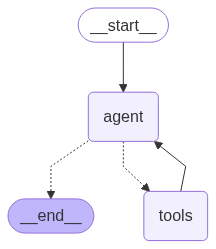

In [47]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

Streaming with Loop:

In [48]:
for output in app.stream({"messages": ["what is the weather in sf"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from agent
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vz0q', 'function': {'arguments': '{"query":"weather in sf"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 941, 'total_tokens': 1023, 'completion_time': 0.149090909, 'prompt_time': 0.033122423, 'queue_time': 0.24746610799999996, 'total_time': 0.182213332}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--115882c9-cd30-4eb4-b883-6f7a0ff6a36c-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': 'call_vz0q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 941, 'output_tokens': 82, 'total_tokens': 1023})]}


here is output from tools
_______
{'messages': [ToolMessage(content='There are many other places in the world to visit like India, Japan, etc.', name='search', id='77eed9fb-af5a-4673-836b-5

## SECTION 6: Adding Memory (State Persistence)

In [49]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

Stores past conversation states.

Useful for follow-up memory (e.g., remembering name).

In [50]:
# Define a new graph
workflow3 = StateGraph(MessagesState)

workflow3.add_node("agent", call_model)
workflow3.add_node("tools", tool_node)

workflow3.add_edge(START, "agent")

workflow3.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

workflow3.add_edge("tools", 'agent')

Compile with checkpointing:

In [51]:
app3 = workflow3.compile(checkpointer = memory)

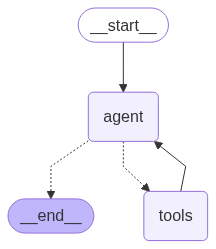

In [52]:
from IPython.display import Image, display

try:
    display(Image(app3.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Configuration for session:

In [53]:
config = {"configurable": {"thread_id": "1"}}

Multi-turn interaction:

In [54]:
events = app3.stream(
    {"messages": ["Hi there! My name is Gurmeet Singh."]}, config, stream_mode="values"
)

In [55]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Gurmeet Singh.
================================== Ai Message ==================================
Tool Calls:
  search (call_s99p)
 Call ID: call_s99p
  Args:
    query: Hi there! My name is Gurmeet Singh.
================================= Tool Message =================================
Name: search

There are many other places in the world to visit like India, Japan, etc.
================================== Ai Message ==================================
Tool Calls:
  search (call_30af)
 Call ID: call_30af
  Args:
    query: Gurmeet Singh
================================= Tool Message =================================
Name: search

There are many other places in the world to visit like India, Japan, etc.
================================== Ai Message ==================================

It seems like you're looking for information about Gurmeet Singh.  Could you tell me more about what you'd

Follow-up memory check:

In [56]:
events = app3.stream(
    {"messages": ["can you tell me what was my name?"]}, config, stream_mode="values"
)

In [57]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

can you tell me what was my name?
================================== Ai Message ==================================

Your name is Gurmeet Singh.


View memory:

In [58]:
memory.get(config)

{'v': 3,
 'ts': '2025-06-06T10:35:25.521206+00:00',
 'id': '1f042c1f-502d-6c23-8008-ae04fe2c7792',
 'channel_versions': {'__start__': '00000000000000000000000000000009.0.23387255775373794',
  'messages': '00000000000000000000000000000010.0.4180906545251136',
  'branch:to:agent': '00000000000000000000000000000010.0.22067031028761996',
  'branch:to:tools': '00000000000000000000000000000006.0.7323577486022568'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000008.0.8347315103883518'},
  'agent': {'branch:to:agent': '00000000000000000000000000000009.0.06702240068988385'},
  'tools': {'branch:to:tools': '00000000000000000000000000000005.0.9119150801307234'}},
 'channel_values': {'messages': [HumanMessage(content='Hi there! My name is Gurmeet Singh.', additional_kwargs={}, response_metadata={}, id='181c8816-a479-4a82-9833-a35ab7b007cb'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_s99p', 'function': {'arguments': '{"q

Scenarios Covered:

1) Simple LLM Graph

2) Tool usage

3) Conditional routing

4) Agent → Tool → Agent cycle (like AutoGPT)

5) Memory persistence across sessions